In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
class SignsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('/content/drive/My Drive/datasets/german signs/train')
#TEST_DIR = Path('gdrive/My Drive/simpsons/unzip_data/test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.png')))
#print(train_val_files)
#test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
len(train_val_files)

38046

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [0]:
val_dataset = SignsDataset(val_files, mode='val')
train_dataset = SignsDataset(train_files, mode ='train')

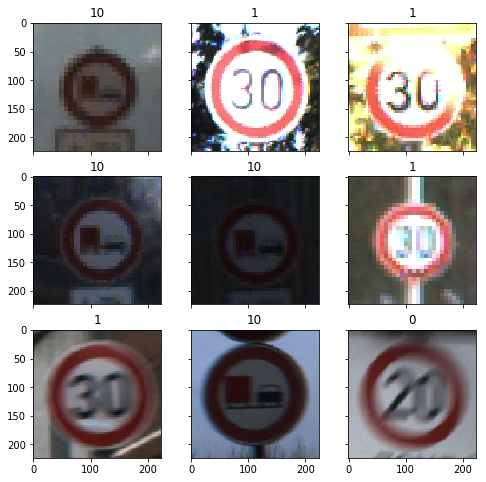

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    count=0
    print(len(train_loader))
    for batch in train_loader:
        inputs, labels = batch['image'].to(DEVICE), batch['label'].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        print(processed_data, end=" ")
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch in val_loader:
        inputs, labels = batch['image'].to(DEVICE), batch['label'].to(DEVICE)
        

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
if val_dataset is None:
    val_dataset = SignsDataset(val_files, mode='val')
    
train_dataset = SignsDataset(train_files, mode='train')

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(signs_cnn, ex_img.unsqueeze(0))

NameError: ignored

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simpsons_cnn, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simpsons_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [0]:
import itertools
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

In [0]:
from sklearn.metrics import confusion_matrix

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
with torch.no_grad():
    for batch in val_dataset:
        predictions = predict_one_sample(simpsons_cnn, batch[0].unsqueeze(0))
        y_test = torch.from_numpy(np.array([batch[1]]))
        predictions = torch.from_numpy(predictions)
        _, predictions = torch.max(predictions, 1)
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y_test), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

feature_names = np.unique(val_dataset.labels)

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(len(np.unique(val_dataset.labels))))
# Выведем её
plot_confusion_matrix(cm, np.unique(val_dataset.labels), normalize=True)


In [0]:
np.unique(val_dataset.labels).shape

In [0]:
len(val_dataset.labels)

# ***RESNET***

***Используем аугментированный датасет размером около 60к изображений***

In [0]:
import torch
from torchvision import models
signs_cnn = models.resnet18(pretrained=True).cuda()

In [0]:
def r_train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(list(model.parameters()),
                                                       lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
num_features = 512
n_classes = len(np.unique(train_val_labels))
print(n_classes)
signs_cnn.fc = nn.Linear(num_features, n_classes)
signs_cnn = signs_cnn.cuda()

43


In [0]:
history = r_train(train_dataset, val_dataset, model=signs_cnn, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

476
64 128 192 256 320 384 448 512 576 640 704 768 832 896 960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568 5632 5696 5760 5824 5888 5952 6016 6080 6144 6208 6272 6336 6400 6464 6528 6592 6656 6720 6784 6848 6912 6976 7040 7104 7168 7232 7296 7360 7424 7488 7552 7616 7680 7744 7808 7872 7936 8000 8064 8128 8192 8256 8320 8384 8448 8512 8576 8640 8704 8768 8832 8896 8960 9024 9088 9152 9216 9280 9344 9408 9472 9536 9600 9664 9728 9792 9856 9920 9984 10048 10112 10176 10240 10304 10368 10432 10496 10560 10624 10688 10752 10816 10880 10944 11008 11072 11136 11200 11264 11328 11392 11456 11520 11584 11648 11712 11776 11840 11904 11968 12032 12096 12160 12224 12288 12352 12416 1248

epoch:  12%|█▎        | 1/8 [3:58:37<27:50:19, 14317.03s/it]


Epoch 001 train_loss: 0.3435     val_loss 0.0218 train_acc 0.9251 val_acc 0.9946
476
64 128 192 256 320 384 448 512 576 640 704 768 832 896 960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568 5632 5696 5760 5824 5888 5952 6016 6080 6144 6208 6272 6336 6400 6464 6528 6592 6656 6720 6784 6848 6912 6976 7040 7104 7168 7232 7296 7360 7424 7488 7552 7616 7680 7744 7808 7872 7936 8000 8064 8128 8192 8256 8320 8384 8448 8512 8576 8640 8704 8768 8832 8896 8960 9024 9088 9152 9216 9280 9344 9408 9472 9536 9600 9664 9728 9792 9856 9920 9984 10048 10112 10176 10240 10304 10368 10432 10496 10560 10624 10688 10752 10816 10880 10944 11008 11072 11136 11200 11264 11328 11392 11456 11520 11584 

epoch:  25%|██▌       | 2/8 [4:04:42<16:53:09, 10131.55s/it]


Epoch 002 train_loss: 0.0358     val_loss 0.0142 train_acc 0.9896 val_acc 0.9955
476
64 128 192 256 320 384 448 512 576 640 704 768 832 896 960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568 5632 5696 5760 5824 5888 5952 6016 6080 6144 6208 6272 6336 6400 6464 6528 6592 6656 6720 6784 6848 6912 6976 7040 7104 7168 7232 7296 7360 7424 7488 7552 7616 7680 7744 7808 7872 7936 8000 8064 8128 8192 8256 8320 8384 8448 8512 8576 8640 8704 8768 8832 8896 8960 9024 9088 9152 9216 9280 9344 9408 9472 9536 9600 9664 9728 9792 9856 9920 9984 10048 10112 10176 10240 10304 10368 10432 10496 10560 10624 10688 10752 10816 10880 10944 11008 11072 11136 11200 11264 11328 11392 11456 11520 11584 

epoch:  38%|███▊      | 3/8 [4:10:46<10:00:05, 7201.17s/it]


Epoch 003 train_loss: 0.0086     val_loss 0.1342 train_acc 0.9977 val_acc 0.9700
476
64 128 192 256 320 384 448 512 576 640 704 768 832 896 960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568 5632 5696 5760 5824 5888 5952 6016 6080 6144 6208 6272 6336 6400 6464 6528 6592 6656 6720 6784 6848 6912 6976 7040 7104 7168 7232 7296 7360 7424 7488 7552 7616 7680 7744 7808 7872 7936 8000 8064 8128 8192 8256 8320 8384 8448 8512 8576 8640 8704 8768 8832 8896 8960 9024 9088 9152 9216 9280 9344 9408 9472 9536 9600 9664 9728 9792 9856 9920 9984 10048 10112 10176 10240 10304 10368 10432 10496 10560 10624 10688 10752 10816 10880 10944 11008 11072 11136 11200 11264 11328 11392 11456 11520 11584 

epoch:  50%|█████     | 4/8 [4:16:47<5:43:16, 5149.18s/it]


Epoch 004 train_loss: 0.0160     val_loss 0.0142 train_acc 0.9959 val_acc 0.9962
476
64 128 192 256 320 384 448 512 576 640 704 768 832 896 960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568 5632 5696 5760 5824 5888 5952 6016 6080 6144 6208 6272 6336 6400 6464 6528 6592 6656 6720 6784 6848 6912 6976 7040 7104 7168 7232 7296 7360 7424 7488 7552 7616 7680 7744 7808 7872 7936 8000 8064 8128 8192 8256 8320 8384 8448 8512 8576 8640 8704 8768 8832 8896 8960 9024 9088 9152 9216 9280 9344 9408 9472 9536 9600 9664 9728 9792 9856 9920 9984 10048 10112 10176 10240 10304 10368 10432 10496 10560 10624 10688 10752 10816 10880 10944 11008 11072 11136 11200 11264 11328 11392 11456 11520 11584 

epoch:  62%|██████▎   | 5/8 [4:22:52<3:05:41, 3713.84s/it]


Epoch 005 train_loss: 0.0023     val_loss 0.0016 train_acc 0.9994 val_acc 0.9993
476
64 128 192 256 320 384 448 512 576 640 704 768 832 896 960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568 5632 5696 5760 5824 5888 5952 6016 6080 6144 6208 6272 6336 6400 6464 6528 6592 6656 6720 6784 6848 6912 6976 7040 7104 7168 7232 7296 7360 7424 7488 7552 7616 7680 7744 7808 7872 7936 8000 8064 8128 8192 8256 8320 8384 8448 8512 8576 8640 8704 8768 8832 8896 8960 9024 9088 9152 9216 9280 9344 9408 9472 9536 9600 9664 9728 9792 9856 9920 9984 10048 10112 10176 10240 10304 10368 10432 10496 10560 10624 10688 10752 10816 10880 10944 11008 11072 11136 11200 11264 11328 11392 11456 11520 11584 

KeyboardInterrupt: ignored

In [0]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

NameError: ignored

In [0]:
# Установим размер классифицируемых изображений
PIC_SIZE = 50
# Путь к предобработанным данным
data_path = '/content/drive/My Drive/datasets/sweden signs/data/'
# Путь, куда сохраним модель
model_save_path = '/content/drive/My Drive/datasets/sweden signs/signs_classifier.pth'

In [0]:
import pandas as pd
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

In [0]:
class SignsDataset(Dataset):
    """Road signs dataset."""

    def __init__(self, csv_file, root_dir, transform=None, no_labels=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.signs_frame = pd.read_csv(csv_file)
        print(f'{len(self.signs_frame)} samples loaded')
        
        self.root_dir = root_dir
        self.transform = transform
        self.no_labels = no_labels
        
        # В тестовом датасете нет ответов
        if not self.no_labels:
            # Cоздаём массив label->index и массив index->label
            self.labels = self.signs_frame['label'].unique()
            self.label_indexes = {}
            for i, label in enumerate(self.labels):
                self.label_indexes[label] = i

    def __len__(self):
        return len(self.signs_frame)

    def __getitem__(self, idx):
        # Загрузим изображение и приведём к размеру 50х50
        img_name = self.root_dir + self.signs_frame.iloc[idx, 0]
        image = Image.open(img_name)
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
        # Применим преобразования изображения (например аугментацию)
        if self.transform:
            image = self.transform(image)
            
        # Для тестового датасета не нужны ответы
        if not self.no_labels:
            # В роли ответа будем давать номер label
            label_string = self.signs_frame.iloc[idx, 1]
            label = self.label_indexes[label_string]
        
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image}
            
        return sample

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
dataset = SignsDataset(data_path + 'train.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor())

indicies = np.arange(len(dataset))

np.random.seed(0)
np.random.shuffle(indicies)

# Разбиение датасета на train и validation
train_sampler = SubsetRandomSampler(indicies[:int(len(dataset)*0.99)])
validation_sampler = SubsetRandomSampler(indicies[int(len(dataset)*0.99):])

# DataLoader достаёт данные из dataset батчами
signsTrainLoader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
signsValidationLoader = DataLoader(dataset, batch_size=32, sampler=validation_sampler)

2503 samples loaded


In [0]:
n_classes = 17
n_features = 512
signs_cnn.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(n_features, 256),
    nn.Linear(256, 128),
    nn.Linear(128, n_classes)
                            )

In [0]:
def r1_train(train_loader1, val_loader1, model, epochs):
    train_loader = train_loader1
    val_loader = val_loader1

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(list(model.parameters()), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
signs_cnn = signs_cnn.cuda()

In [0]:
history = r1_train(signsTrainLoader, signsValidationLoader, model=signs_cnn, epochs=1)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

78
32 64 96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576 608 640 672 704 736 768 800 832 864 896 928 960 992 1024 1056 1088 1120 1152 1184 1216 1248 1280 1312 1344 1376 1408 1440 1472 1504 1536 1568 1600 1632 1664 1696 1728 1760 1792 1824 1856 1888 1920 1952 1984 2016 2048 2080 2112 2144 2176 2208 2240 2272 2304 2336 2368 2400 2432 2464 

epoch: 100%|██████████| 1/1 [00:14<00:00, 14.87s/it]

2477 loss 0.10929990469278421

Epoch 001 train_loss: 0.1093     val_loss 1.3066 train_acc 0.9645 val_acc 0.8846


In [0]:
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
test_dataset = SignsDataset(data_path + 'test.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor(),
                       no_labels=True)


# DataLoader достаёт данные из dataset батчами
signsTestLoader = DataLoader(test_dataset, batch_size=1)

610 samples loaded


In [0]:
answer = []

for batch in signsTestLoader:
    predictions = signs_cnn(batch['image'].to(DEVICE))
    _, predictions = torch.max(predictions, 1)
    answer.append(dataset.labels[predictions[0]])    

prediction_df = test_dataset.signs_frame
    
prediction_df['label'] = pd.Series(answer)
prediction_df.to_csv('/content/drive/My Drive/datasets/sweden signs/signs_sub1.csv', index=False)